In [11]:
import pandas as pd
import os
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# (tqdmをpandasで使えるように設定)
tqdm.pandas()
print("Libraries imported.")

Libraries imported.


In [24]:
# --- 1. 設定 ---

# 訓練データセットのパス
TRAINING_FILE = "data/processed/training_dataset_abstract.csv"

# 使用するベースモデル（SciBERT）
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# トークナイザのロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

print("Tokenizer loaded.")

Tokenizer loaded.


In [25]:
# --- 2. データセットの読み込み ---
print("Loading dataset...")
df = pd.read_csv(TRAINING_FILE)

# NaN（空のアブストラクト）が含まれている場合に備えて削除
df = df.dropna(subset=['abstract_a', 'abstract_b', 'label'])
print(f"Loaded {len(df)} pairs.")

Loading dataset...
Loaded 35315 pairs.


In [26]:
# --- 3. 各ペアのトークン長を計算 ---

def count_tokens(row):
    # tokenizer(A, B) は [CLS] A [SEP] B [SEP] の形式で
    # トークン化し、特殊トークンも自動で含めます。
    tokenized = tokenizer(row["abstract_a"], row["abstract_b"])
    # input_idsの長さが、モデルに入力される最終的なトークン数です。
    return len(tokenized['input_ids'])

print("Calculating token lengths for all pairs (this may take a moment)...")
# .progress_applyで進捗バーを表示しながら計算
df['token_length'] = df.progress_apply(count_tokens, axis=1)

print("Token length calculation complete.")

Calculating token lengths for all pairs (this may take a moment)...


  0%|          | 0/35315 [00:00<?, ?it/s]

Token length calculation complete.


In [27]:
# --- 4. 分析結果の表示 ---
MAX_LENGTH = 512

print("\n--- Token Length Statistics ---")
display(df['token_length'].describe())

# 512トークンを超えるペアの割合を計算
truncated_count = (df['token_length'] > MAX_LENGTH).sum()
total_count = len(df)
percentage = (truncated_count / total_count) * 100

print("\n" + "="*50)
print(f"   Max Length (Truncation limit): {MAX_LENGTH} tokens")
print(f"Pairs EXCEEDING max length: {truncated_count:,} / {total_count:,}")
print(f"Percentage of pairs to be truncated: {percentage:.2f}%")
print("="*50)


--- Token Length Statistics ---


,token_length
count,35315.000000
mean,714.858644
std,459.690431
min,48.000000
25%,454.000000
50%,603.000000
75%,807.000000
max,9080.000000



   Max Length (Truncation limit): 512 tokens
Pairs EXCEEDING max length: 23,213 / 35,315
Percentage of pairs to be truncated: 65.73%



--- Token Length Distribution Histogram ---


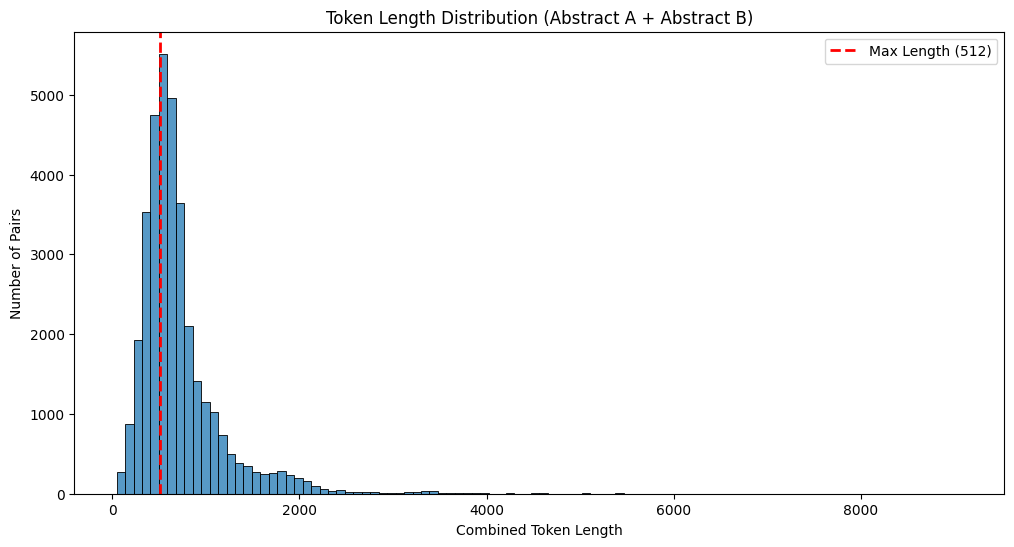

In [28]:
# --- 5. 分布の可視化 ---
print("\n--- Token Length Distribution Histogram ---")

plt.figure(figsize=(12, 6))
sns.histplot(df['token_length'], bins=100, kde=False)

# 512トークンの位置に赤い線を引く
plt.axvline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')

plt.title('Token Length Distribution (Abstract A + Abstract B)')
plt.xlabel('Combined Token Length')
plt.ylabel('Number of Pairs')
plt.legend()
plt.show()

## セットアップ

In [6]:
# --- 1. 必要なライブラリのインストール ---
# Hugging Faceのライブラリと、GPUでの訓練を高速化するライブラリをインストール
!pip install torch transformers datasets accelerate scikit-learn

# --- 2. Google Driveのマウント ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# --- 3. プロジェクトのルートディレクトリに移動 ---
# %cd コマンドで、Colabの作業ディレクトリをあなたのプロジェクトフォルダに変更します。
%cd /content/drive/MyDrive/研究/S2ORCRanker

print("\n--- Setup Complete ---")

/content/drive/MyDrive/研究/S2ORCRanker

--- Setup Complete ---


## 設定

In [8]:
import pandas as pd
import os
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

# --- 1. 設定 ---

# 訓練データセットのパス (Drive内のパス)
TRAINING_FILE = "data/processed/training_dataset_abstract.csv"

# 使用するベースモデル（SciBERT）
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# 訓練済みモデルの保存先 (Drive内のパス)
OUTPUT_MODEL_DIR = "models/cross_encoder_nsp_colab_v1"

# モデルのハイパーパラメータ
MAX_LENGTH = 512       # 入力トークンの最大長
BATCH_SIZE = 16        # ColabのGPU (T4) はローカルPCより強力なので、バッチサイズを大きめに設定
EPOCHS = 3             # 訓練エポック数
LEARNING_RATE = 2e-5   # ファインチューニングの標準的な学習率

print("Configuration set.")
print(f"CUDA available: {torch.cuda.is_available()}")

Configuration set.
CUDA available: False


In [9]:
## データのロードと分割

In [ ]:
# --- 2. データセットの読み込みと準備 ---
print(f"Loading dataset from: {TRAINING_FILE}")
df = pd.read_csv(TRAINING_FILE)

# NaN（空のアブストラクト）が含まれている場合に備えて削除
df = df.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df['label'] = df['label'].astype(int)

print(f"Loaded {len(df)} pairs.")

# Hugging Face Datasets形式に変換
raw_dataset = Dataset.from_pandas(df)

# データセットを訓練用(80%)と検証用(20%)に分割
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)

dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})

print(f"Dataset split: {dataset}")

## Tokenize

In [ ]:
# --- 3. トークナイズ処理 ---
print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    # 手法2 (NSP類似型): 2つのアブストラクトを連結
    # 入力: [CLS] abstract_a [SEP] abstract_b [SEP]
    return tokenizer(
        examples["abstract_a"],
        examples["abstract_b"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

print("Tokenizing dataset (this may take a while)...")
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 訓練に必要なカラムだけを残す
tokenized_datasets = tokenized_datasets.remove_columns(["abstract_a", "abstract_b", "data_paper_doi"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

## モデルのロード

In [ ]:
# --- 4. モデルのロード ---
print(f"Loading model: {MODEL_CHECKPOINT}")
# 2クラス分類（label 0 or 1）のモデルをロード
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=2)
print("Model loaded.")

## 訓練の設定

In [ ]:
# --- 5. 訓練の実行 ---

# 評価指標を計算する関数
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # argmaxで最も確率が高いクラス（0 or 1）を選択
    preds = np.argmax(predictions, axis=1)

    # 評価指標を計算
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",    # 1エポックごとに検証
    save_strategy="epoch",          # 1エポックごとに保存
    load_best_model_at_end=True,    # 訓練終了時に最高のモデルをロード
    push_to_hub=False,
)

print("Training arguments and metrics set.")

## 訓練開始

In [ ]:
# 訓練の実行
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("\n--- Starting Model Training ---")
# このセルを実行すると、GPUを使ったモデルの訓練が開始されます
trainer.train()
print("--- Model Training Complete ---")

## モデルの保存

In [ ]:
# --- 6. モデルの保存 ---
print("Training complete. Saving best model...")
best_model_path = os.path.join(OUTPUT_MODEL_DIR, "best_model")
trainer.save_model(best_model_path)
print(f"Model saved to {best_model_path} (on your Google Drive)")